In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
%matplotlib inline

from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Pre-processing

In [4]:
# Read in Data
data = pd.read_csv('../data/model_data/spatial_df/Lassa_spatialdataset_201219separateyears_labconfirmed.csv')
data.replace('',np.nan,regex = True)
data.dropna(inplace=True)

# Separate data so that we train the model on 2012-2017 data
# and test it's predictive ability against 2018-2019 data
df18 = data[(data['Year'] == 2018)].copy()
df19 = data[(data['Year'] == 2019)].copy()

In [5]:
# Creating LGA names set and then assigning them their indices as values
lga_names = set(data['LGA'])
lga_replace_dict = {value: i for i, value in enumerate(lga_names)}

# Creating Year names set and then assigning them their indices as values
year_names = set(data['Year'])
year_replace_dict = {value: i for i, value in enumerate(year_names)}

# Creating Admin names set and then assigning them their indices as values
administration_names = set(data['admin1Name'])
administration_replace_dict = {value: i for i, value in enumerate(administration_names)}

# Creating Source names set and then assigning them their indices as values
source_names = set(data['Source'])
source_replace_dict = {value: i for i, value in enumerate(source_names)}

In [6]:
# Replaces string values for integer values in dataset
data = data.replace({'LGA':lga_replace_dict, 
                      'Year': year_replace_dict,
                      'admin1Name': administration_replace_dict,
                      'Source': source_replace_dict})

df18 = df18.replace({'LGA':lga_replace_dict, 
                      'Year': year_replace_dict,
                      'admin1Name': administration_replace_dict,
                      'Source': source_replace_dict})

df19 = df19.replace({'LGA':lga_replace_dict, 
                      'Year': year_replace_dict,
                      'admin1Name': administration_replace_dict,
                      'Source': source_replace_dict})

In [7]:
# Features in the dataset that were already normalized or dont need normalizing
ignore_norm_cols_array = ["AgriProp_ESA", "UrbanProp_ESA", "ForestProp_ESA", "TempMonthlyCoefv_201118_NOAA",
                     "TotalPop2015_PropUrban", "ImprovedHousingPrev_PopWeighted", "Cropland_prop_ESA2015",
                     "Agri_prop_ESA2015", "Urb_prop_ESA2015", "Forest_prop_ESA2015", "PovertyProp_Mean",
                     "PovertyProp_PopWeighted", "LGA", "Year", "admin1Name", "Source"]

# Normalize the data
# FOR NOW: DO NOT NORMALIZE DF18 & DF19
# RUNNING INTO PROBLEMS WITH NUMDIAGCENTRES 
# (AND OTHER FEATURES?) THAT HAVE ONLY 1 UNIQUE VALUE
for heading in data.columns:  
  if heading not in ignore_norm_cols_array:
    data[heading] = ( data[heading] - ( min(data[heading]) ) ) / ( max(data[heading]) - min(data[heading]) )
    #df18[heading] = ( df18[heading] - ( min(df18[heading]) ) ) / ( max(df18[heading]) - min(df18[heading]) )
    #df19[heading] = ( df19[heading] - ( min(df19[heading]) ) ) / ( max(df19[heading]) - min(df19[heading]) )

In [8]:
# Remove these columns
data = data.loc[:, ~data.columns.isin(['Cases', 'Cases_SuspectedUnconfirmed', 'Year', 'Source', 'x', 'y', 'Reports_All'])]
df18 = df18.loc[:, ~df18.columns.isin(['Cases', 'Cases_SuspectedUnconfirmed', 'Year', 'Source', 'x', 'y', 'Reports_All'])].copy()
df19 = df19.loc[:, ~df19.columns.isin(['Cases', 'Cases_SuspectedUnconfirmed', 'Year', 'Source', 'x', 'y', 'Reports_All'])].copy()

In [9]:
# Set target variable as only the confirmed cases of LF; 'Any_Confirmed_Cases' is a binary class
x = data.iloc[:, data.columns != 'Any_Confirmed_Cases']
y = data.iloc[:, data.columns == 'Any_Confirmed_Cases']

# Set target variable for 2018 & 2019 dataset
x18 = df18.iloc[:, df18.columns != 'Any_Confirmed_Cases']
y18 = df18.iloc[:, df18.columns == 'Any_Confirmed_Cases']

x19 = df19.iloc[:, df19.columns != 'Any_Confirmed_Cases']
y19 = df19.iloc[:, df19.columns == 'Any_Confirmed_Cases']

# Retype from float to int
y = y.astype(int)
y18 = y18.astype(int)
y19 = y19.astype(int)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [40]:
clf = XGBClassifier(n_estimators=2, max_depth=4, learning_rate=0.01, objective='binary:logistic')
clf.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=2, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [41]:
y_pred = clf.predict(x_test)
y18_pred = clf.predict(x18)
y19_pred = clf.predict(x19)

In [28]:
from sklearn.metrics import confusion_matrix

cfMatrix = confusion_matrix(y_test, y_pred)
cfMatrix18 = confusion_matrix(y18, y18_pred)
cfMatrix19 = confusion_matrix(y19, y19_pred)

print(f"2012-2017 Data\n {cfMatrix} \n\n 2018 Data\n {cfMatrix18} \n\n 2019 Data\n {cfMatrix19}")

2012-2017 Data
 [[1472    0]
 [  76    0]] 

 2018 Data
 [[685   0]
 [ 89   0]] 

 2019 Data
 [[684   0]
 [ 90   0]]


In [29]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

f1_18 = f1_score(y18, y18_pred)
accuracy_18 = accuracy_score(y18, y18_pred)

f1_19 = f1_score(y19, y19_pred)
accuracy_19 = accuracy_score(y19, y19_pred)

print(f"2012-2017 Data\nF1 Score: {f1}\nAccuracy: {accuracy}\n\n2018 Data\nF1 Score: {f1_18}\nAccuracy: {accuracy_18}\n\n2019 Data\nF1 Score: {f1_19}\nAccuracy: {accuracy_19}")

2012-2017 Data
F1 Score: 0.0
Accuracy: 0.9509043927648578

2018 Data
F1 Score: 0.0
Accuracy: 0.8850129198966409

2019 Data
F1 Score: 0.0
Accuracy: 0.8837209302325582


In [30]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, x_train, y_train, cv=10)
print(scores)
print(f"Mean score: {scores.mean()}")

[0.93763441 0.94193548 0.94193548 0.94193548 0.94396552 0.94396552
 0.94396552 0.94181034 0.94181034 0.94181034]
Mean score: 0.9420768446421949


In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test))
print(classification_report(y18_pred, y18))
print(classification_report(y19_pred, y19))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1548
           1       0.00      0.00      0.00         0

    accuracy                           0.95      1548
   macro avg       0.50      0.48      0.49      1548
weighted avg       1.00      0.95      0.97      1548

              precision    recall  f1-score   support

           0       1.00      0.89      0.94       774
           1       0.00      0.00      0.00         0

    accuracy                           0.89       774
   macro avg       0.50      0.44      0.47       774
weighted avg       1.00      0.89      0.94       774

              precision    recall  f1-score   support

           0       1.00      0.88      0.94       774
           1       0.00      0.00      0.00         0

    accuracy                           0.88       774
   macro avg       0.50      0.44      0.47       774
weighted avg       1.00      0.88      0.94       774



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this be

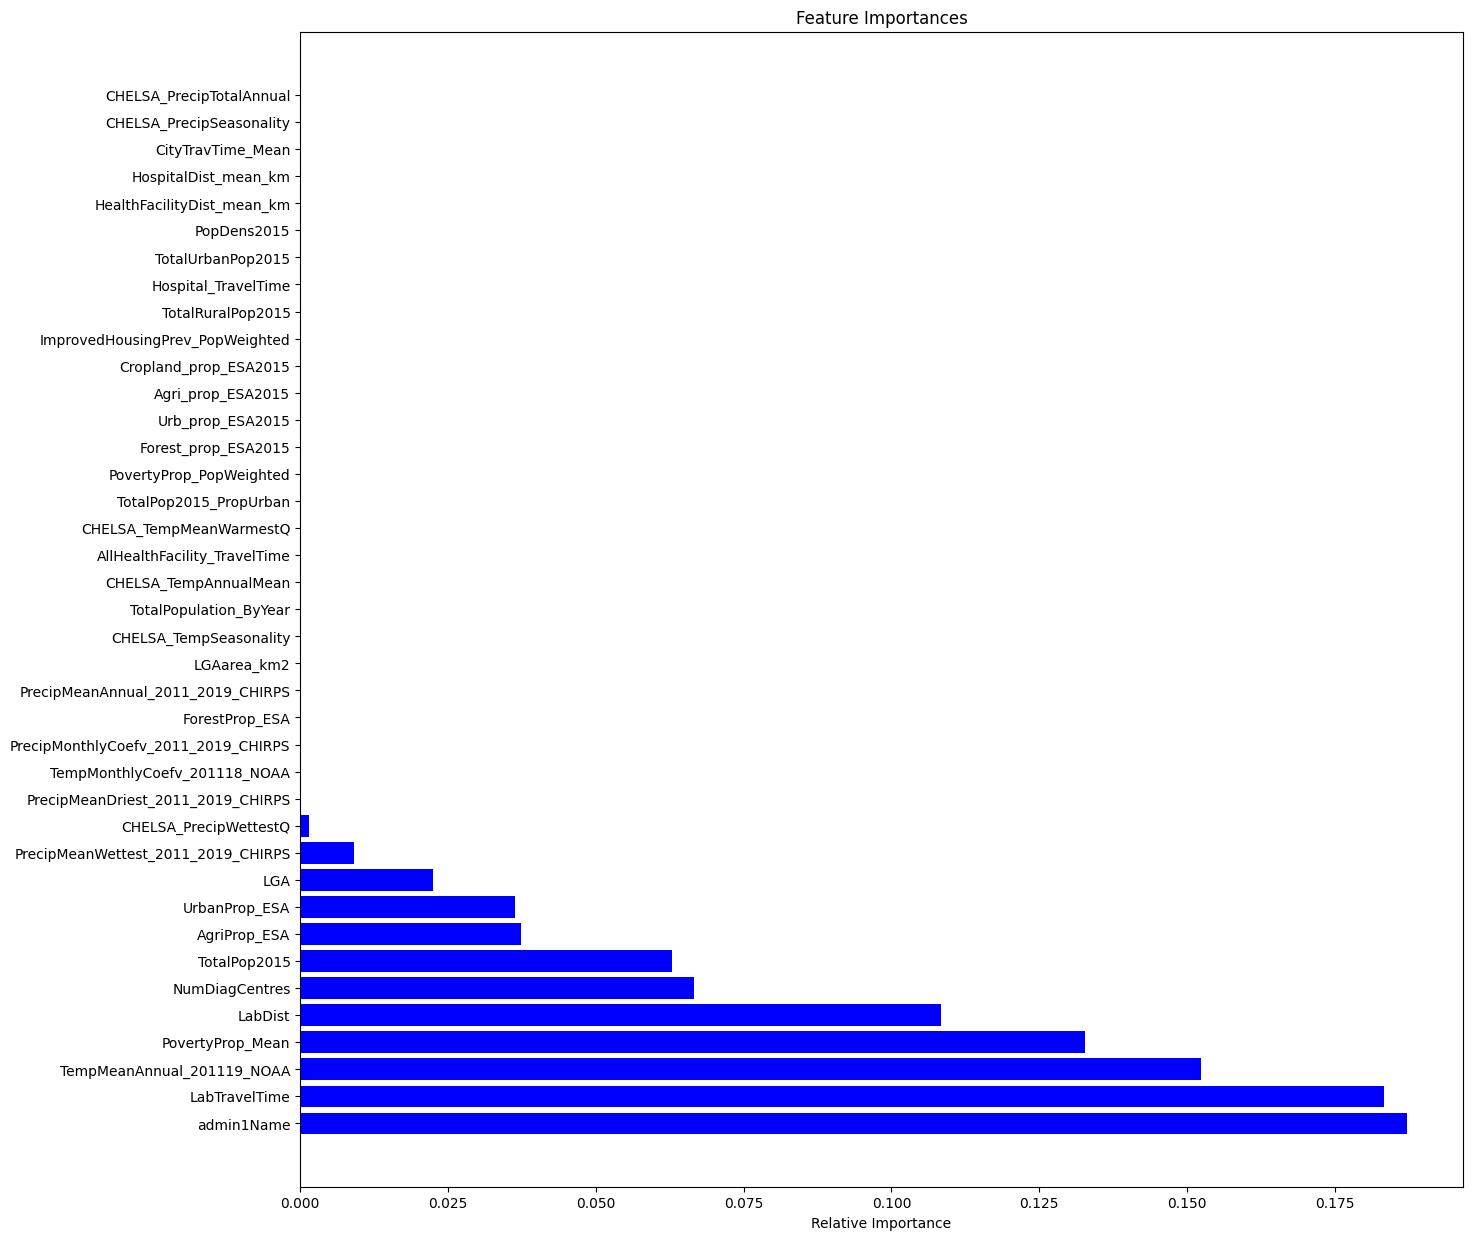

In [42]:
features = x_test.columns
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(figsize=(15,15))

ax.set_title("Feature Importances")
ax.barh(range(len(indices)), importances[indices], color='b', align='center')
ax.set_yticks(range(len(indices)), [features[i] for i in indices])
ax.set_xlabel('Relative Importance')
plt.show()

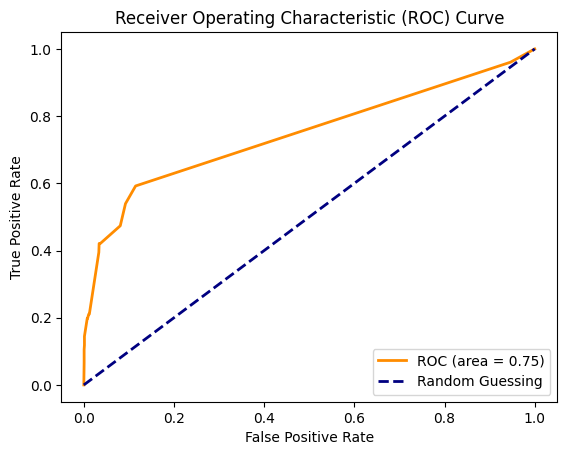

In [43]:
from sklearn.metrics import roc_curve, auc
# Do we need this line?
# yer = clf.predict_proba(x_test)

# AUC / ROC for 2012-2017
y_score = clf.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, color='darkorange', lw=2,label='ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

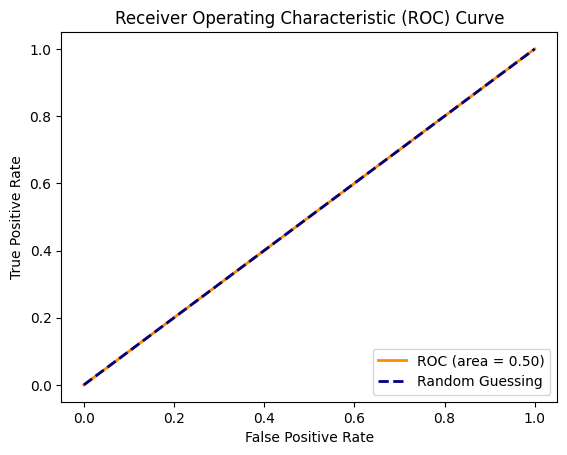

In [44]:
# AUC / ROC for 2018
y18_score = clf.predict_proba(x18)[:, 1]

fpr, tpr, thresholds = roc_curve(y18, y18_score)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, color='darkorange', lw=2,label='ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

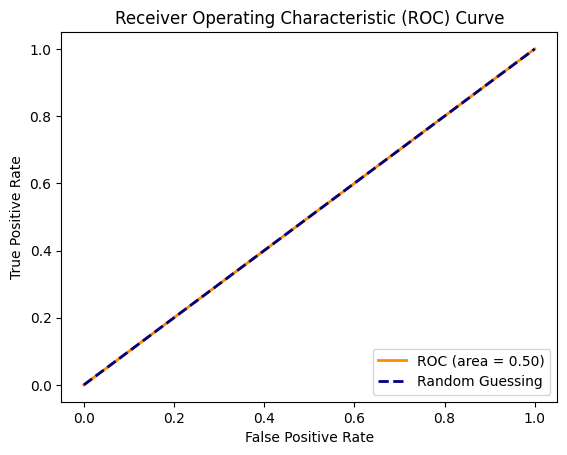

In [45]:
# AUC / ROC for 2019
y19_score = clf.predict_proba(x19)[:, 1]

fpr, tpr, thresholds = roc_curve(y19, y19_score)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, color='darkorange', lw=2,label='ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


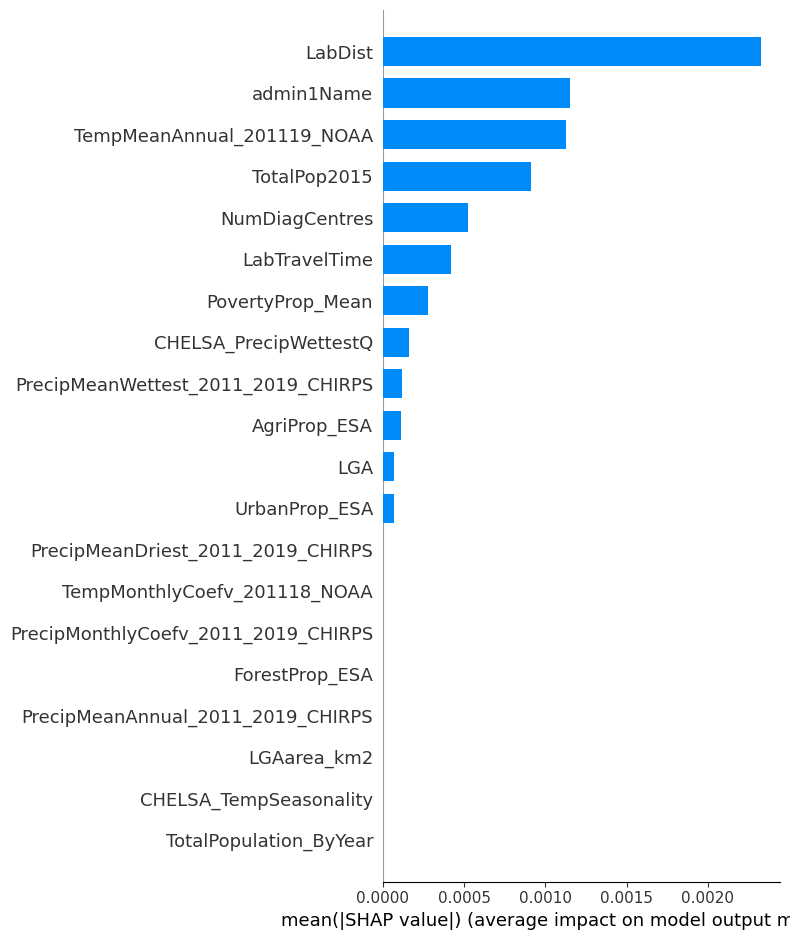

In [46]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, plot_type='bar')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


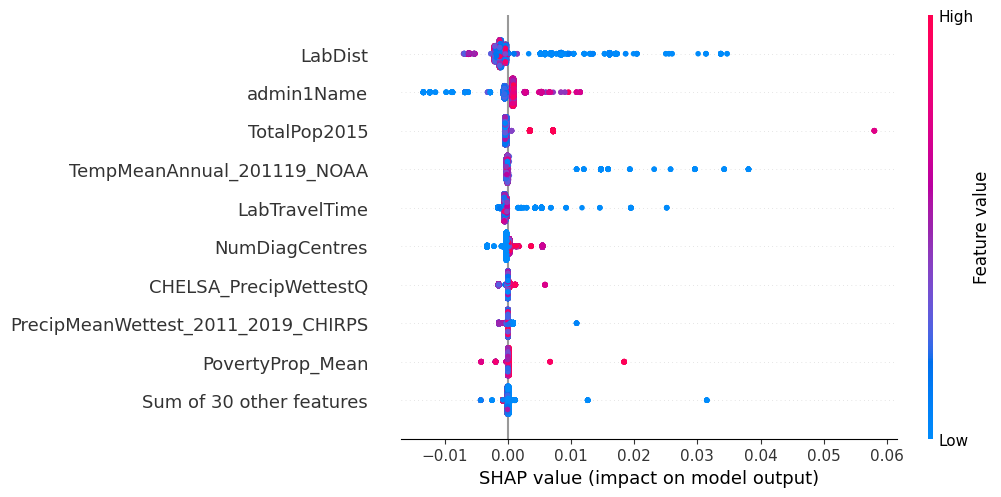

In [47]:
explainer = shap.TreeExplainer(clf, x_train, check_additivity=False)
shap_values = explainer(x_train, check_additivity=False)
shap.plots.beeswarm(shap_values)

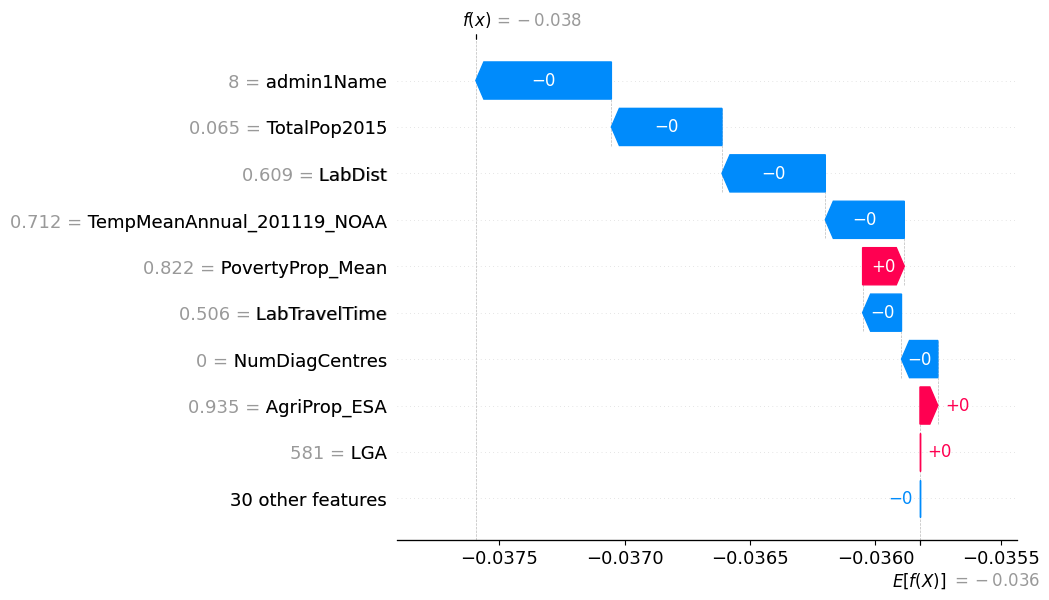

In [48]:
shap.plots.waterfall(shap_values[0])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


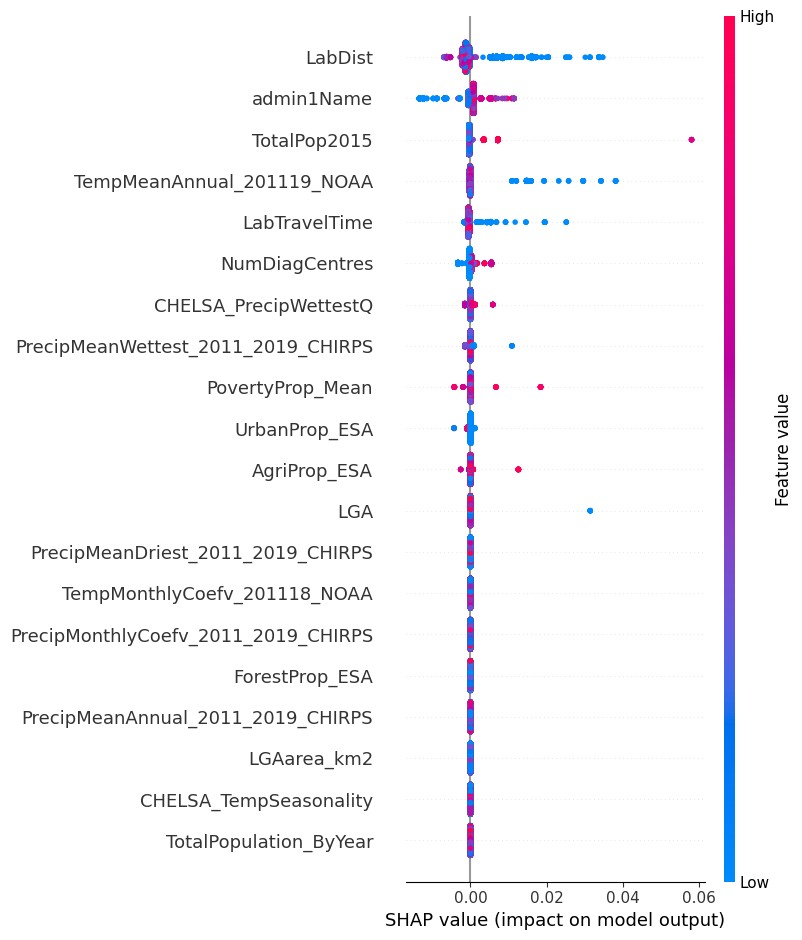

In [49]:
shap.summary_plot(shap_values, x_train)

## SHAP Heat Map/ Correlation Matrix

<Axes: >

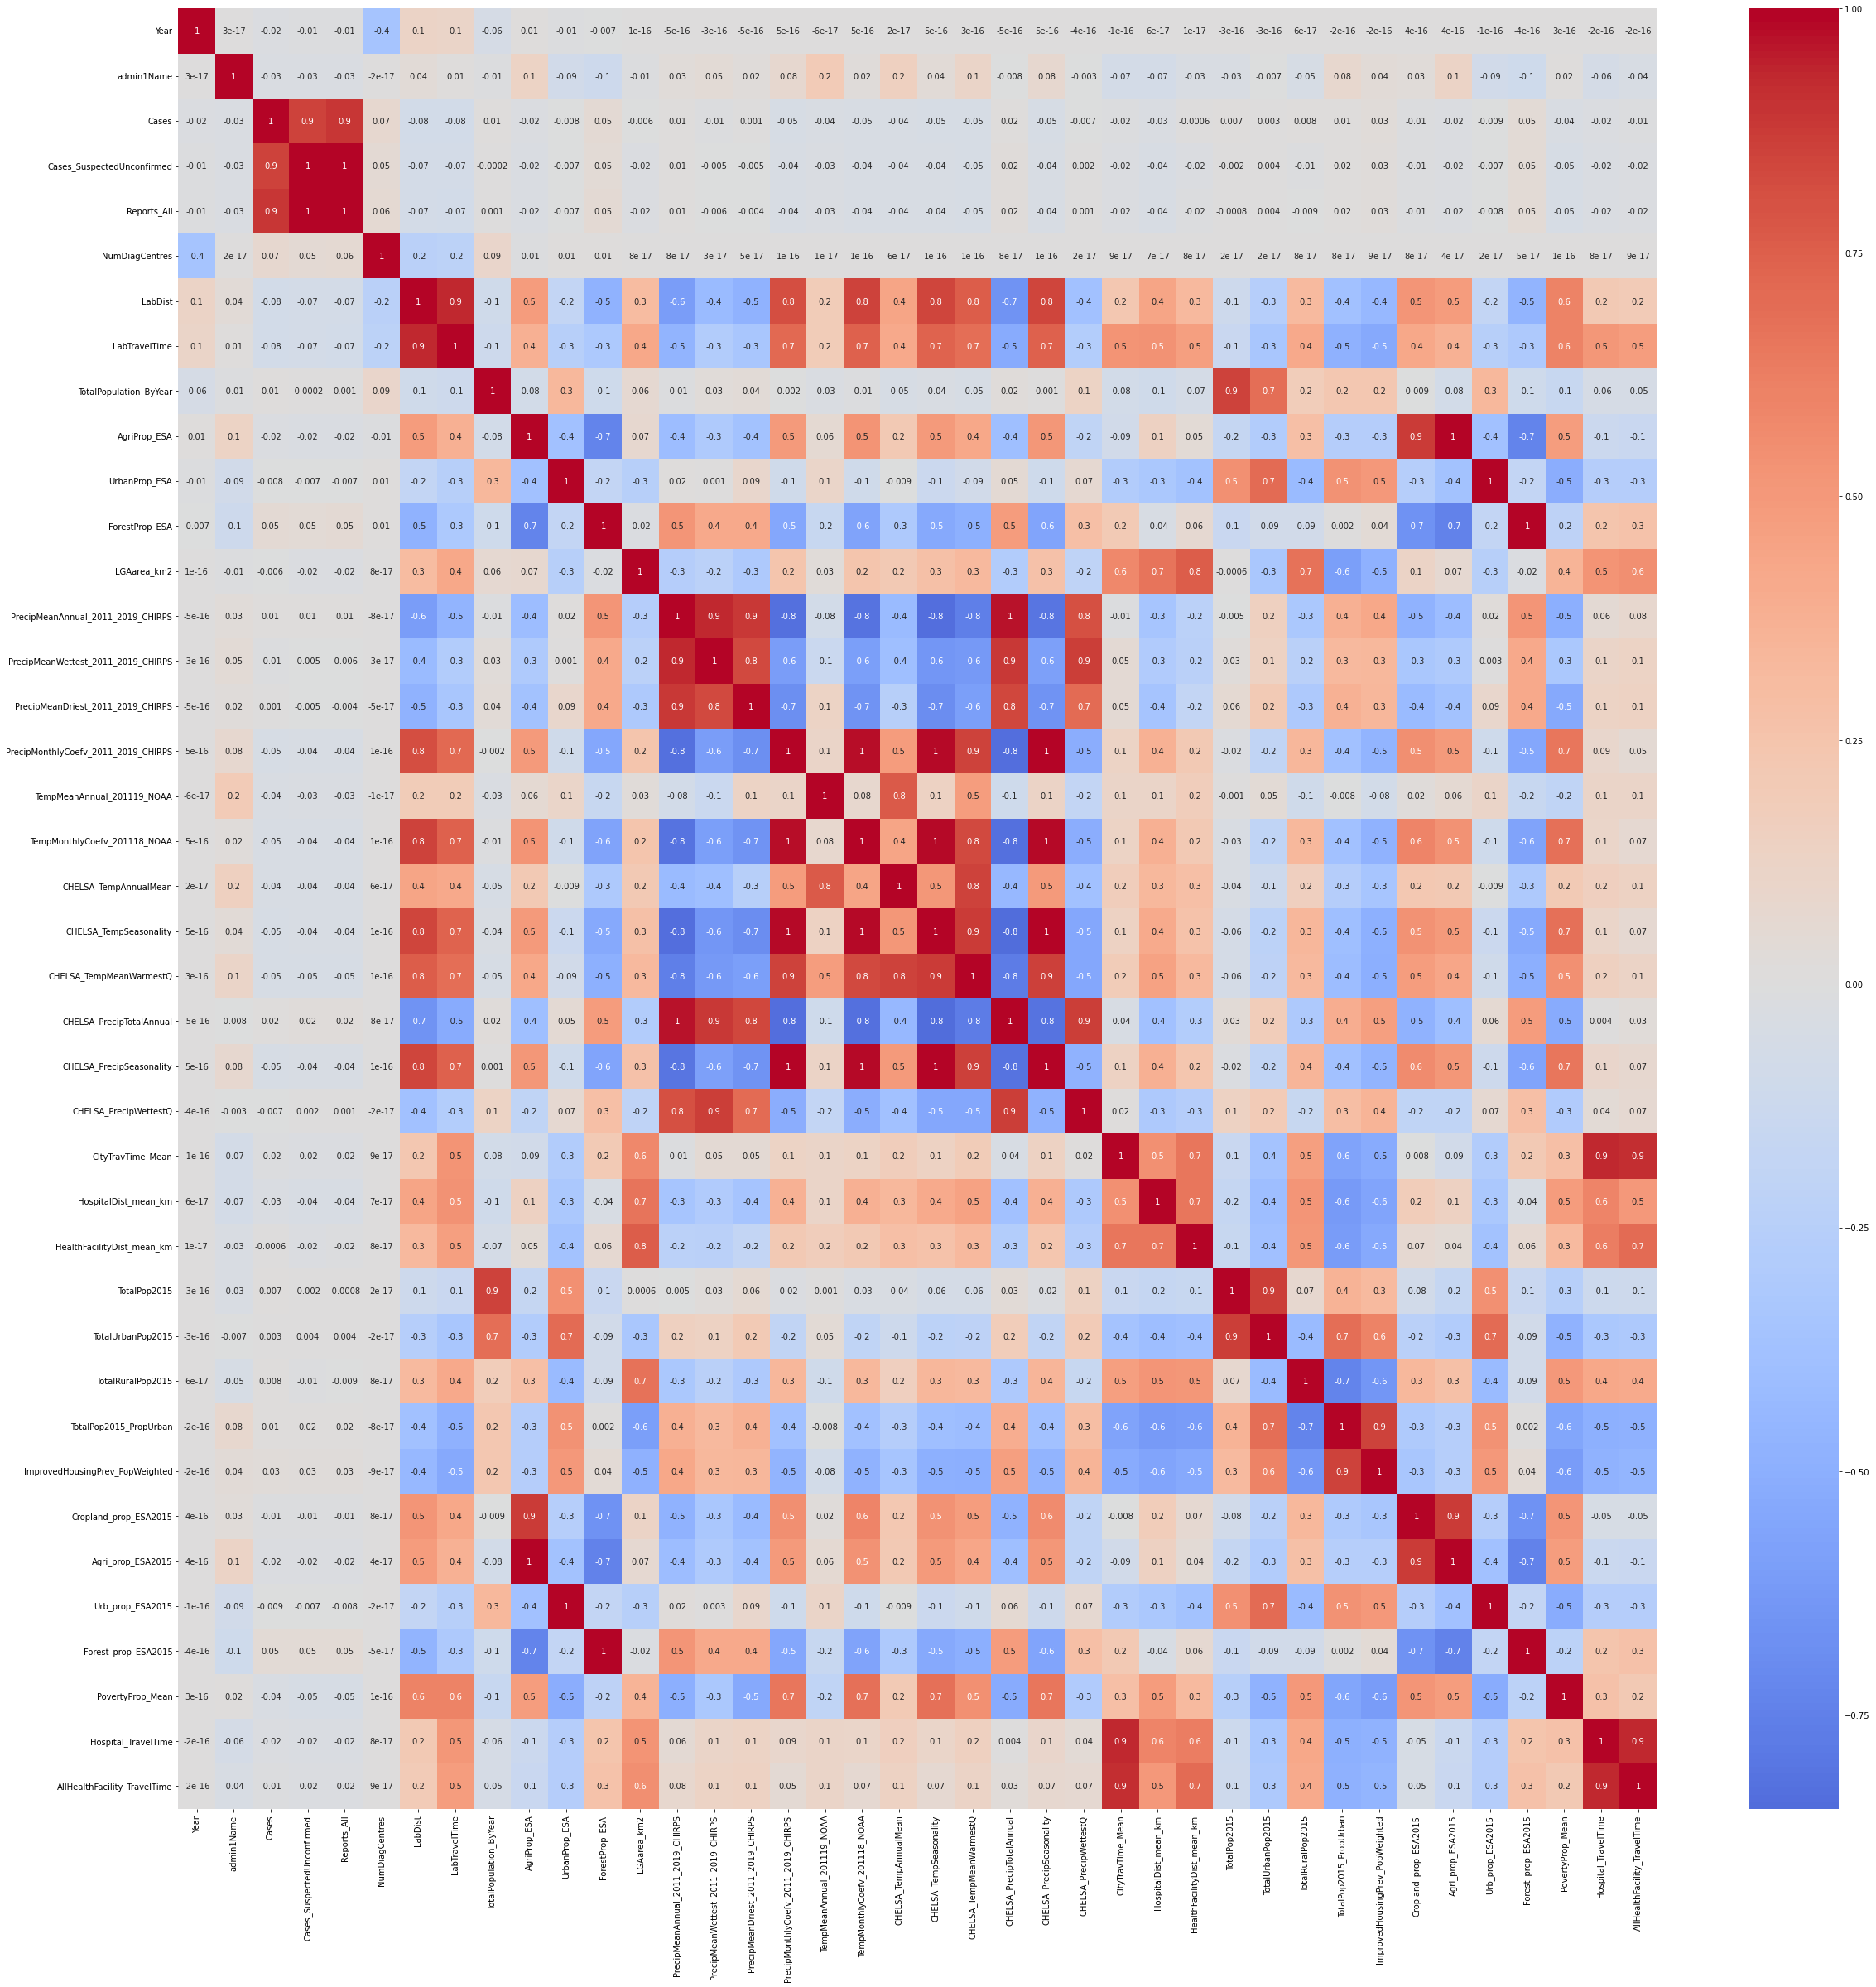

In [7]:
shap_related_columns = ['Year', 'admin1Name', 'Cases', 
                        'Cases_SuspectedUnconfirmed', 'Reports_All', 'NumDiagCentres',
                        'LabDist', 'LabTravelTime', 'TotalPopulation_ByYear', 'AgriProp_ESA',
                        'UrbanProp_ESA', 'ForestProp_ESA', 'LGAarea_km2',
                        'PrecipMeanAnnual_2011_2019_CHIRPS',
                        'PrecipMeanWettest_2011_2019_CHIRPS',
                        'PrecipMeanDriest_2011_2019_CHIRPS',
                        'PrecipMonthlyCoefv_2011_2019_CHIRPS', 'TempMeanAnnual_201119_NOAA',
                        'TempMonthlyCoefv_201118_NOAA', 'CHELSA_TempAnnualMean',
                        'CHELSA_TempSeasonality', 'CHELSA_TempMeanWarmestQ',
                        'CHELSA_PrecipTotalAnnual', 'CHELSA_PrecipSeasonality',
                        'CHELSA_PrecipWettestQ', 'CityTravTime_Mean', 'HospitalDist_mean_km',
                        'HealthFacilityDist_mean_km', 'TotalPop2015',
                        'TotalUrbanPop2015', 'TotalRuralPop2015', 'TotalPop2015_PropUrban',
                        'ImprovedHousingPrev_PopWeighted', 'Cropland_prop_ESA2015',
                        'Agri_prop_ESA2015', 'Urb_prop_ESA2015', 'Forest_prop_ESA2015',
                        'PovertyProp_Mean', 'Hospital_TravelTime',
                        'AllHealthFacility_TravelTime'
                       ]
s_plt = len(shap_related_columns)
fig, ax = plt.subplots(figsize=(s_plt, s_plt))

# Create new DataFrame with just shap related columns
shap_data = data[shap_related_columns]

corr_matrix = pd.DataFrame(shap_data, columns=shap_related_columns).corr()

sns.heatmap(corr_matrix,
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.1g')

## XGBoost Model

In [13]:
x_data = data.iloc[:, data.columns != 'Cases']
x_train, x_test, y_train, y_test = train_test_split(x_data, data['Cases'], test_size=0.2)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
# Create model instance
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=0.01, objective='binary:logistic')
# Fit Model
bst.fit(x_train, y_train)
# Make Predictions
preds = bst.predict(x_test)

sample_index=5
print(f"Predicted Value: {preds[sample_index]}")
print(f"Actual Value: {y_test[sample_index]}")
print(f"Accuracy: {bst.score(x_test, y_test)}")

s=0
for n,i in enumerate(preds):
    if i == y_test[n]:
        s+=1
print(f"Manual Accuracy: {float(s)/float(len(y_test))}")

Predicted Value: 0
Actual Value: 0
Accuracy: 0.9467312348668281
Manual Accuracy: 0.9467312348668281


In [53]:
explainer = shap.Explainer(bst, x_train)
shap_values = explainer(x_train)

 98%|===================| 160456/163449 [00:14<00:00]        

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


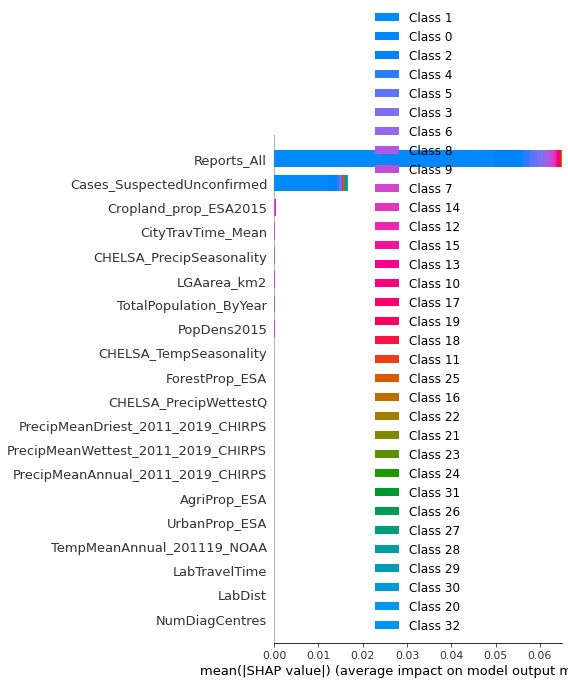

In [60]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, plot_type="bar")

## Beeswarm Plot Stuff

In [ ]:

fig, axes = plt.subplots(nrows=8, ncols=5, figsize=(20,20))

axes = axes.flatten()

for i,feature in enumerate(shap_data.columns):
    sns.swarmplot(x=feature, data=shap_data, ax=axes[i])
    axes[i].set_title(feature)
    
for j in range(len(shap_data.columns), len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()


#fig, ax = plt.subplots(figsize=(20,15))
#sns.stripplot(x='LabTravelTime', data=shap_data, size=1)
#sns.swarmplot(x='LabTravelTime', data=shap_data)
#plt.show()


## Does this even work
# for feature in shap_data.columns:
    #shap.summary_plot(shap_values[:, feature], shap_data[feature], plot_type="beeswarm", show=False)
    #plt.title(feature)
    #plt.show()

79.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
97.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
15.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
97.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
89.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
96.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
97.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
89.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
98.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
96.7% of the points cannot be placed; you may want to d

63.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
91.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


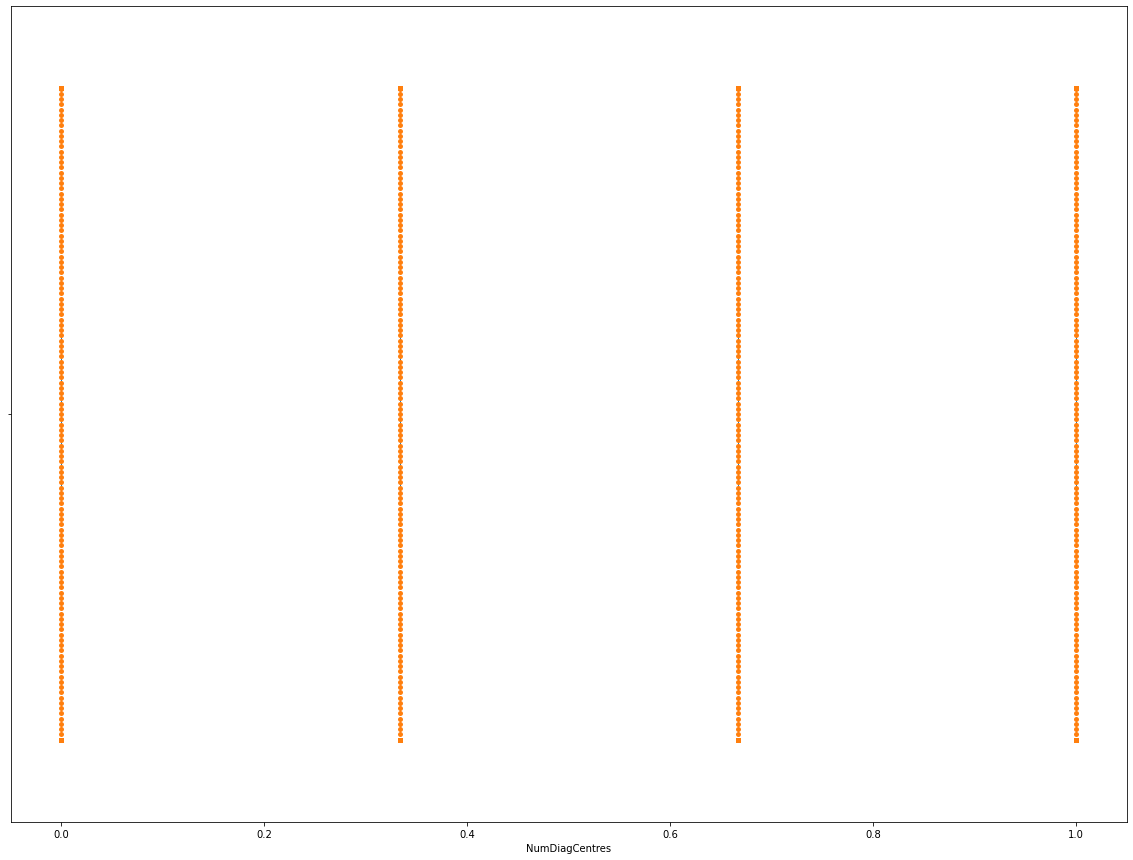

In [62]:
fig, ax = plt.subplots(figsize=(20,15))
sns.stripplot(x='NumDiagCentres', data=shap_data, size=1)
sns.swarmplot(x='NumDiagCentres', data=shap_data)
plt.show()